# Model Building

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from pydotplus import graph_from_dot_data
import pandas
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
final_pts_1 = pd.read_csv('updated_final_pts.csv')

In [280]:
#create dummies for categorical variables
dummies = pd.DataFrame([])

PointServer_dummies = pd.get_dummies(final_pts_1.PointServer.astype('category'), 
                                     prefix="PointServer", drop_first=True)
P1BreakPoint_dummies = pd.get_dummies(final_pts_1.P1BreakPoint.astype('category'), 
                                      prefix="P1BP", drop_first=True)
P2BreakPoint_dummies = pd.get_dummies(final_pts_1.P2BreakPoint.astype('category'), 
                                      prefix="P2BP", drop_first=True)
match_id_dummies = pd.get_dummies(final_pts_1.match_id_simplified.astype('category'), 
                                  prefix="match", drop_first=True)
gender_dummies = pd.get_dummies(final_pts_1.gender.astype('category'), prefix="gender", drop_first=True)


In [286]:
dummies = pd.concat([PointServer_dummies,P1BreakPoint_dummies,
                     P2BreakPoint_dummies,gender_dummies], axis=1)

In [288]:
cat_to_drop1 = ['PointServer','P1BreakPoint','P2BreakPoint','match_id_simplified',
                'gender','match_id']
continuous = final_pts_1
for col in cat_to_drop1:
    continuous = continuous.drop(col, axis=1)

continuous['PointNumber'] = continuous['PointNumber'].astype(int)

In [289]:
#standardize continuous predictors
scaler = sklearn.preprocessing.StandardScaler()
scaled_continuous = scaler.fit_transform(continuous)
scaled_continuous = pd.DataFrame(scaled_continuous, columns=continuous.columns)

In [290]:
final_pts_1['PointWinner'] = [0 if ele == 2 else ele for ele in final_pts_1['PointWinner']]

/Users/sashaepelbaum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [291]:
sum(final_pts_1['PointWinner'])

11562

In [293]:
#target variable
Y = final_pts_1['PointWinner']

In [294]:
predictors = pd.merge(dummies, scaled_continuous, on=dummies.index)
predictors = predictors.drop(['PointWinner'], axis=1).set_index('key_0')


In [295]:
predictors.head()

,PointServer_2,P1BP_1,P2BP_1,gender_W,SetNo,P1GamesWon,P2GamesWon,GameNo,PointNumber,P1PointsWon,...,P1DistRun_last5,P2DistRun_last5,AvgRallyCount,last_5_RallyCount,P1NetPointWinRate,P2NetPointWinRate,P1NetPointWinRate_last5,P2NetPointWinRate_last5,P1_Score,P2_Score
key_0,,,,,,,,,,,,,,,,,,,,,
1101-14,1,0,0,0,-1.273038,-0.908209,-1.418723,-1.264238,-1.538701,-1.497535,...,1.367517,1.367517,1.026313,1.696312,-0.279803,-0.281274,-0.273222,-0.275117,1.162279,1.162279
1101-17,1,0,0,0,-1.273038,-0.908209,-1.418723,-1.264238,-1.494452,-1.439575,...,2.165127,2.165127,1.820122,2.114014,-0.279803,-0.281274,-0.273222,-0.275117,1.931585,1.931585
1101-19,1,0,0,0,-1.273038,-0.908209,-1.418723,-1.264238,-1.464954,-1.439575,...,3.025023,3.025023,2.502095,3.053845,-0.279803,-0.281274,-0.273222,-0.275117,1.162279,1.162279
1101-21,1,0,0,0,-1.273038,-0.908209,-1.418723,-1.264238,-1.435455,-1.410596,...,2.469635,2.469635,2.076424,2.218440,-0.279803,-0.281274,-0.273222,-0.275117,1.162279,1.162279
1101-22,1,0,0,0,-1.273038,-0.908209,-1.418723,-1.264238,-1.420706,-1.410596,...,2.225592,2.225592,2.433577,2.114014,-0.279803,-0.281274,-0.273222,-0.275117,-1.145638,-1.145638


## Base Model

In [297]:
from sklearn.dummy import DummyClassifier
X = predictors
y = Y
dummy_clf = DummyClassifier()
dummy_clf.fit(X, y)

dummy_clf.predict(X)

#WHAT DOES THIS SCORE MEAN???
dummy_clf.score(X, y)

0.5016755886321104

# Train-Test Split for Model Building

In [298]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


# Basic Decision Tree

In [299]:
clf= DecisionTreeClassifier(criterion='entropy', max_depth = 10)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [300]:
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
# Image(graph.create_png())

In [302]:
# Show graph
# Image(graph.create_png())

In [303]:
y_preds = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.7541340295909487


# Model Evaluation Functions

In [370]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_preds)
classes = ['P2 Wins', 'P1 Wins']

In [371]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [372]:
def matrix_interpretation( y_test, y_preds):
    confusion = sklearn.metrics.confusion_matrix(y_test, y_preds)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print('There are {0} True Positives'.format(TP))
    print('There are {0} True Negatives'.format(TN))
    print('There are {0} False Positives'.format(FP))
    print('There are {0} False Negatives'.format(FN))


In [373]:
def evaluate_class(y_test, y_preds):

    acc = accuracy_score(y_test, y_preds)
    precision = sklearn.metrics.precision_score(y_test, y_preds)
    recall = sklearn.metrics.recall_score(y_test,y_preds)
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_preds)
    #Overall, how often is the classifier correct?
    print('Accuracy is :{0}'.format(acc))
    #When a positive value is predicted, how often is the prediction correct?
    print('Precision is :{0}'.format(precision))
    #What proportion of actual positives was identified correctly?
    print('Recall is :{0}'.format(recall))
    #What does this mean?!
    print('\nAUC is :{0}'.format(round(roc_auc, 2)))
    return acc, precision, recall, roc_auc


## Testing Model Evaluation Functions on Basic Decision Tree

### Confusion Matrix

Confusion Matrix, without normalization
[[2347 1048]
 [ 647 2852]]


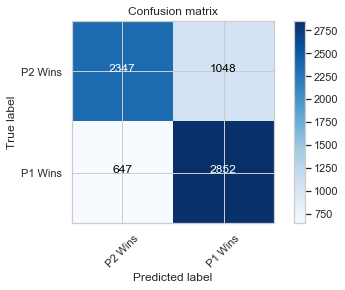

In [374]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Matrix Interpretation, Accuracy, Precision, Recall

In [375]:
matrix_interpretation(y_test,y_preds)

There are 2852 True Positives
There are 2347 True Negatives
There are 1048 False Positives
There are 647 False Negatives


In [376]:
evaluate_class(y_test, y_preds)

Accuracy is :0.7541340295909487
Precision is :0.7312820512820513
Recall is :0.8150900257216348

AUC is :0.75


(0.7541340295909487,
 0.7312820512820513,
 0.8150900257216348,
 0.7532003884131002)

# Logistic Regression

In [377]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [378]:
log_y_preds = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

Accuracy is :0.6521612996808819
Precision is :0.6708035991312442
Recall is :0.6178908259502716

AUC is :0.65
There are 2162 True Positives
There are 2334 True Negatives
There are 1061 False Positives
There are 1337 False Negatives
Confusion Matrix, without normalization
[[2334 1061]
 [1337 2162]]


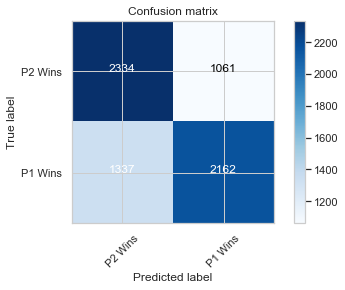

In [386]:
log_cm = confusion_matrix(y_test,log_y_preds)
log_classes = ['P2 Wins', 'P1 Wins']

evaluate_class(y_test, log_y_preds)
matrix_interpretation(y_test,log_y_preds)
plot_confusion_matrix(log_cm, log_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [314]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

1    2397
2    2333
0    2164
Name: PointWinner, dtype: int64
1    0.347694
2    0.338410
0    0.313896
Name: PointWinner, dtype: float64


In [315]:
# First calculate the probability scores of each of the datapoints:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)


y_score
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [316]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7229607786108465


AUC: 0.7229607786108465


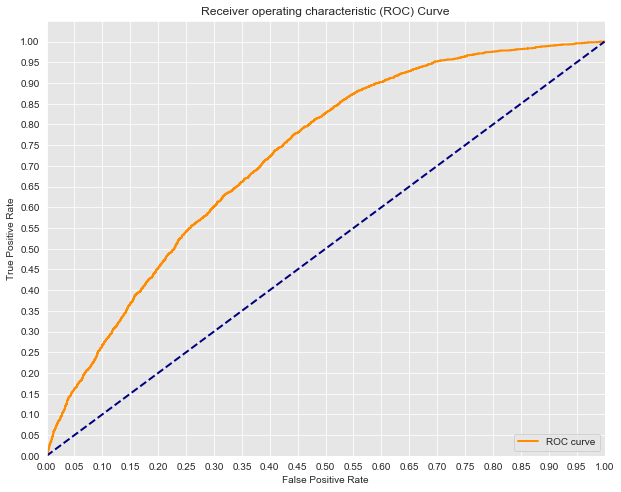

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [318]:
dictionary = dict(zip(list(X_train.columns), list(logreg.coef_[0])))
dictionary

{'PointServer_2': -0.5989539397861534,
 'P1BP_1': 0.18051501729132352,
 'P2BP_1': 0.6866791097734426,
 'gender_W': 0.5268558841926938,
 'SetNo': -0.036492853418136066,
 'P1GamesWon': -0.027401226082886348,
 'P2GamesWon': 0.2605629578161859,
 'GameNo': -0.25998079147502945,
 'PointNumber': 15.6500027234447,
 'P1PointsWon': -6.317394594380406,
 'P2PointsWon': -9.457294772519116,
 'ServeNumber': 0.18967106766530836,
 'prior_avg_speed': 0.2653612001035224,
 'last_5_avg_speed': 0.024401145315596378,
 'AceRate': -0.10005198979878463,
 'AceRate_last_5': 0.046443377932616006,
 'DF_last_5': -0.014530496891343253,
 'DoubleFault_rate': -0.04848436655735586,
 'P1UnfErrRate': 0.0263450759641459,
 'P2UnfErrRate': 0.0263450759641459,
 'P1UnfErr_last5': 0.008455979268664881,
 'P2UnfErr_last5': 0.008455979268664881,
 'P1AceRate': 0.04484063885782322,
 'P2AceRate': 0.12474992965004081,
 'P1AceRate_last5': -0.0018292683374696863,
 'P2AceRate_last5': -0.0018292683374696863,
 'P1NetRate': 0.016301893305824

# Random Forest

## Simple Random Forest

In [319]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_features=3, max_depth= 7, criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [320]:
forest_pred = forest.predict(X_test)
RForest_Eval = evaluate_class(y_test, forest_pred)

Accuracy is :0.7106179286335944
Precision is :0.6705215419501134
Recall is :0.8450985995998856

AUC is :0.71


In [321]:
rf_cm = confusion_matrix(y_test,forest_pred)
rf_classes = ['P1 Wins', 'P2 Wins']

Confusion Matrix, without normalization
[[1942 1453]
 [ 542 2957]]


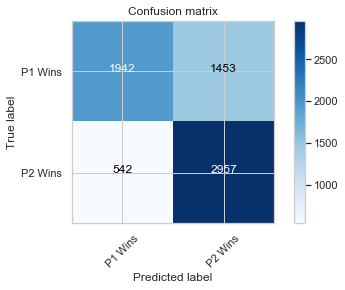

In [380]:
plot_confusion_matrix(rf_cm, rf_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [323]:
matrix_interpretation(y_test,forest_pred)

There are 1942 True Positives
There are 2957 True Negatives
There are 542 False Positives
There are 1453 False Negatives


## Random Forest with GridSearch CV

In [324]:
rfc=RandomForestClassifier(random_state=42)

In [325]:
param_grid = { 
    'n_estimators': [100],
    'max_features':[3,5,7],
    'max_depth' : [5,7],
    'criterion' :['gini', 'entropy']
}

In [326]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [327]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 7, 'max_features': 7, 'n_estimators': 100}

### Best RandomForest from GridSearch

In [328]:
best_rfc = RandomForestClassifier(random_state=42, 
                                max_features=7, n_estimators= 100,
                                max_depth=7, criterion='gini')
best_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [329]:
best_rfc_preds = best_rfc.predict(X_test)

Accuracy is :0.7119234116623151
Precision is :0.6616107669301431
Recall is :0.8851100314375536

AUC is :0.71
Confusion Matrix, without normalization
[[1811 1584]
 [ 402 3097]]
There are 3097 True Positives
There are 1811 True Negatives
There are 1584 False Positives
There are 402 False Negatives


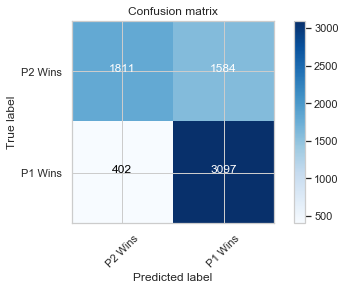

In [382]:
Best_RForest_Eval = evaluate_class(y_test, best_rfc_preds)

best_rf_cm = confusion_matrix(y_test,best_rfc_preds)
rf_classes = ['P2 Wins', 'P1 Wins']

plot_confusion_matrix(best_rf_cm, rf_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

matrix_interpretation(y_test,best_rfc_preds)

# AdaBoost and GradientBoost

In [331]:
# Instantiate an AdaBoostClassifier
AdaBoost_class = AdaBoostClassifier(random_state=42)

AdaBoost_class.fit(X_train, y_train)

# AdaBoost model predictions
adaboost_test_preds = AdaBoost_class.predict(X_test)


Accuracy is :0.6489701189440092
Precision is :0.6566947429567238
Recall is :0.6461846241783367

AUC is :0.65
Confusion Matrix, without normalization
[[2213 1182]
 [1238 2261]]
There are 2261 True Positives
There are 2213 True Negatives
There are 1182 False Positives
There are 1238 False Negatives


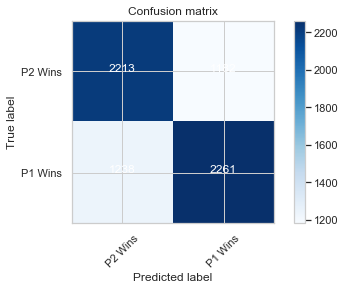

In [384]:
#evaluating AdaBoost
adaboost_eva=evaluate_class(y_test, adaboost_test_preds)

ada_boost_cm = confusion_matrix(y_test,adaboost_test_preds)
ada_classes = ['P2 Wins', 'P1 Wins']

plot_confusion_matrix(ada_boost_cm, ada_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

matrix_interpretation(y_test, adaboost_test_preds)

In [334]:
# Instantiate an GradientBoostingClassifier
gboost_class = GradientBoostingClassifier(random_state=42)

gboost_class.fit(X_train, y_train)


# GradientBoosting model predictions
g_boost_test_preds = gboost_class.predict(X_test)
prob_g_boost_preds = gboost_class.predict_proba(X_test)


Accuracy is :0.7523933855526544
Precision is :0.7080817464003716
Recall is :0.8713918262360675

AUC is :0.75
Confusion Matrix, without normalization
[[2138 1257]
 [ 450 3049]]
There are 3049 True Positives
There are 2138 True Negatives
There are 1257 False Positives
There are 450 False Negatives


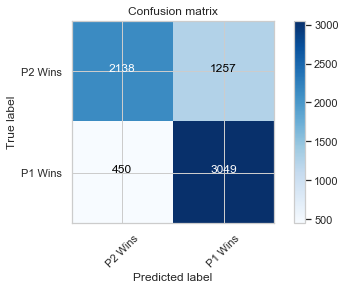

In [385]:
#evaluating GradientBoosting
GradientBoosting_eva=evaluate_class(y_test, g_boost_test_preds)

g_boost_cm = confusion_matrix(y_test,g_boost_test_preds)
g_classes = ['P2 Wins', 'P1 Wins']

plot_confusion_matrix(g_boost_cm, g_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

matrix_interpretation(y_test, g_boost_test_preds)

In [336]:
# g_boost_test_preds
# prob_g_boost_preds = gboost_class.predict_proba(X_test)
def plot_ROC_curve(y_test, y_pred_prob):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('ROC Curve for Anaylst Rating Classifier');
    plt.xlabel('False Positive Rate (1 - Specificity)');
    plt.ylabel('True Positive Rate (Sensitivity)');
    plt.grid(True);

In [392]:
preds = [i[1] for i in prob_g_boost_preds]

AUC: 0.8389235131771291


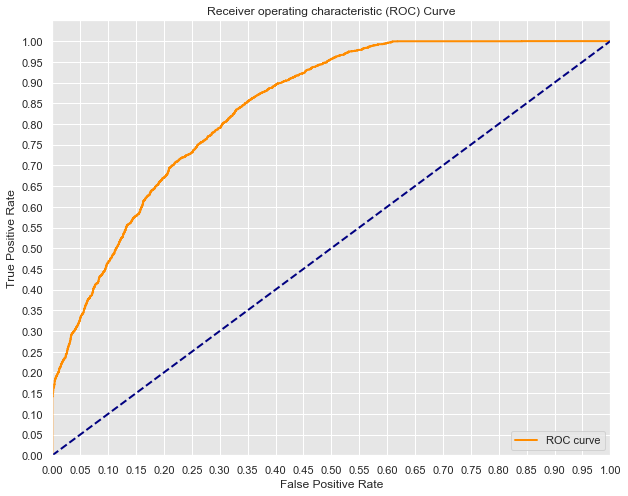

In [395]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_scores_gb = gboost_class.decision_function(X_validation_sub)
fpr_gb, tpr_gb, _ = roc_curve(y_validation_sub, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
